# Pytorch Example


In [1]:
import numpy as np
from numpy import genfromtxt

import matplotlib.pyplot as plt  # for plotting

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

import seaborn as sns

from sklearn.metrics import confusion_matrix

np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

Import the data file

In [2]:
data = genfromtxt('DVN_20181101.csv', delimiter=',') 
t = data[:-1,0]
QV = data[:-1,1]
P = data[:-1,2]
NB = data[:-1,3]
NS = data[:-1,4]
VB = data[:-1,5]
VS = data[:-1,6]

In [3]:
print(VS[:6])
print(P[:6])
print(QV[:6])

[  0.   0.   0.   0.   0. 900.]
[32.605 32.575 32.59  32.57  32.585 32.64 ]
[0.      0.63465 0.0009  0.00103 0.00045 0.00088]


<ipython-input-4-8174dff55a3a>:9: RuntimeWarning: invalid value encountered in true_divide
  rho = (VB-VS)/(VB+VS)


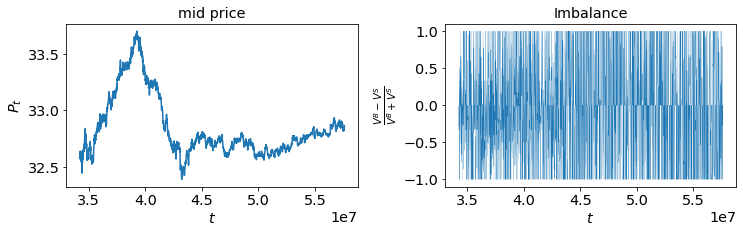

In [4]:
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.plot(t,P)
plt.xlabel(r'$t$')    
plt.ylabel(r'$P_t$')
plt.title('mid price')

plt.subplot(1,2,2)
rho = (VB-VS)/(VB+VS)
rho[(VB+VS)==0] = 0
plt.plot(t,rho,linewidth=0.2)
plt.xlabel(r'$t$')    
plt.ylabel(r'$\frac{V^B-V^S}{V^B+V^S}$')
plt.title('Imbalance')

plt.subplots_adjust(wspace=0.3)
plt.show()

In [5]:
# standardize features...
def Normalize(x, p):
    # linear transformation to make 
    #   P(a X +b < -1 ) = p
    #   P(a X +b > 1 ) = p

    q = np.quantile(x,[p, 1-p])
    a = 2.0 /(q[1]-q[0])
    b = 1.0 - a * q[1]
    
    return a*x+b 

def LogNormalize(x, p):
    
    y = np.log(1 + x / np.mean(x[x!=0],axis=0) )
    
    return Normalize(y, p)



In [6]:
print(rho)

[ 0.       0.       0.      ...  0.7964   0.27229 -1.     ]


0.4026
0.3731


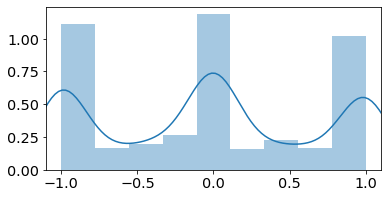

In [7]:
# test out the normalization
x = Normalize(rho, 0.05  )
print("{0:.4f}".format(np.sum(x<0)/len(x)))
print("{0:.4f}".format(np.sum(x>0)/len(x)))

plt.figure(figsize=(6,3))
sns.distplot(x,bins=np.linspace(-1,1,10), kde=True, hist=True)
plt.xlim((-1.1,1.1))
plt.show()

0.0000
0.0462


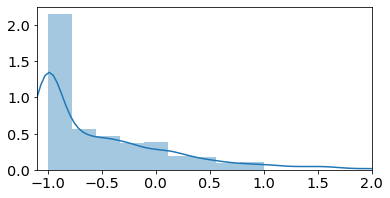

In [8]:
# test out log normalization
x = LogNormalize(VB, 0.05  )
print("{0:.4f}".format(np.sum(x<-1)/len(x)))
print("{0:.4f}".format(np.sum(x>1)/len(x)))

plt.figure(figsize=(6,3))
sns.distplot(x,bins=np.linspace(-1,1,10), kde=True, hist=True)
plt.xlim((-1.1,2))
plt.show()

In [9]:
def NormalizeFeatures(P, VB, VS, QV, p):

    x = np.empty((P.shape[0], 5))

    # use price changes as a feature
    x[1:,0] = P[1:]-P[:-1]
    x[0,0] = 0
    
    x[:,0] = Normalize(x[:,0], p)
    
    # buy and sell volume  s features
    x[:,1] = LogNormalize(VB, p)
    x[:,2] = LogNormalize(VS, p)
    
    # order-imbalance
    rho = (VB-VS)/(VB+VS)
    rho[(VB+VS)==0] = 0
    x[:,3] = Normalize(rho,p)
    
    # quadratic variation
    x[:,4] = LogNormalize(QV,p)
     
    return x

<ipython-input-9-b8e75ed0759a>:16: RuntimeWarning: invalid value encountered in true_divide
  rho = (VB-VS)/(VB+VS)


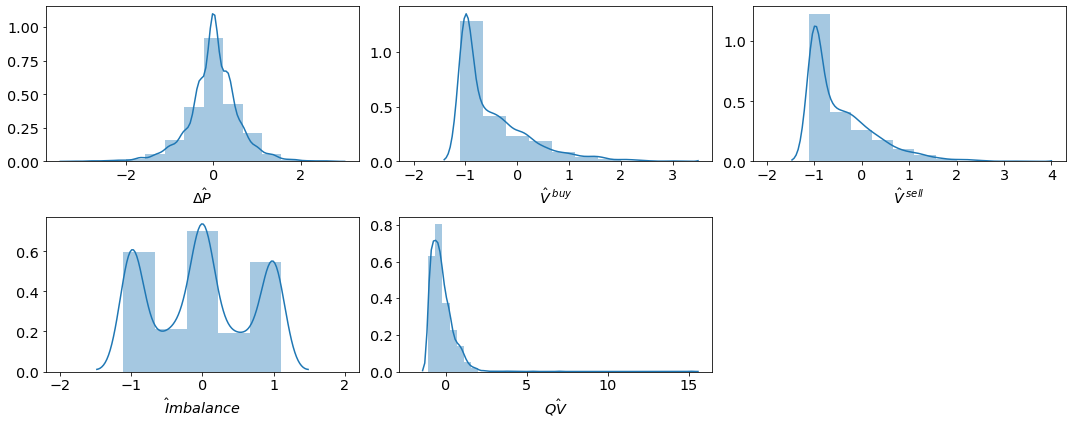

In [10]:
# let's generate histograms of the transformed features
x = NormalizeFeatures(P, VB, VS, QV, 0.05)

plt.figure(figsize=(15,6))

plt.subplot(2,3,1)
sns.distplot(x[:,0],bins=(np.linspace(-2,2,10)),  kde=True, hist=True)
plt.xlabel('$\hat{\Delta P}$')

plt.subplot(2,3,2)
sns.distplot(x[:,1],bins=(np.linspace(-2,2,10)),  kde=True, hist=True)
plt.xlabel('$\hat{V}^{\;buy}$')

plt.subplot(2,3,3)
sns.distplot(x[:,2],bins=(np.linspace(-2,2,10)),  kde=True, hist=True)
plt.xlabel('$\hat{V}^{\;sell}$')

plt.subplot(2,3,4)
sns.distplot(x[:,3],bins=(np.linspace(-2,2,10)),  kde=True, hist=True)
plt.xlabel('$\hat{I}mbalance$')

plt.subplot(2,3,5)
sns.distplot(x[:,4],bins=(np.linspace(-2,2,10)),  kde=True, hist=True)
plt.xlabel('$\hat{QV}$')

plt.tight_layout()
plt.show()

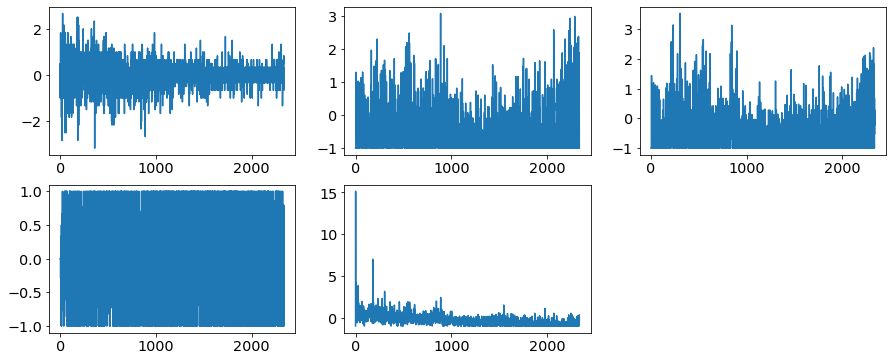

In [11]:
# show features as a time-series
plt.figure(figsize=(15,6))
for k in range(x.shape[1]):
    plt.subplot(2,3,k+1)
    plt.plot(x[:,k])

plt.show()

In [12]:
def GenerateTargets(QV,  mRegimes):
    
    # future price changes over m-steps
    p = 1/mRegimes * np.arange(1,mRegimes)
    qtl = np.quantile(QV, p)
    
    y = np.zeros(len(QV)).astype(int)
    y[QV<qtl[0]] = 0 
    
    for i in range(1,len(qtl)):
        y[(QV>=qtl[i-1])&(QV<qtl[i])] = i
        
    y[QV>=qtl[-1]] = mRegimes-1
    
    return y

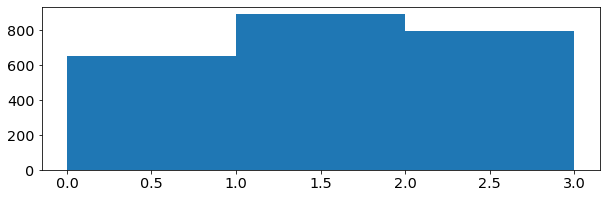

[0 0 2 2 1]


In [13]:
mRegimes = 3
label = GenerateTargets(QV,mRegimes)

plt.figure(figsize=(10,3))
plt.hist(label,np.arange(0,mRegimes+1))
plt.show()

print(label[-5:])

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyNet(nn.Module):
    
    def __init__(self, nlags, nNodes, mRegimes ):
        super(MyNet, self).__init__()
        
        # 5 x nlags input layer, mRegimes output channels (QV), 2 hidden layers with nUnits units each
        self.f_in_to_h1 = nn.Linear( 5 * nlags, nNodes)
        self.f_h1_to_h2 = nn.Linear(nNodes, nNodes)
        self.f_h2_to_out = nn.Linear(nNodes, mRegimes)

    def forward(self, x):
        
#        # input into 1st hidden layer
        h1 = torch.sigmoid(self.f_in_to_h1(x))
        
#        # 1st hidden to 2nd hidden layer
        h2 = torch.sigmoid(self.f_h1_to_h2(h1))
            
#        # 2nd hidden layer to output layer
        y = self.f_h2_to_out(h2)
        
        return y

In [15]:
def GetMinibatch(i, MinibatchSize, nlags):
    # grab a minibatch starting at i and using all features from nlags
    
    xb = np.empty((MinibatchSize, nlags*5))
    
    for k in range(0,MinibatchSize):
        xb[k,:] = np.reshape(x[i+k-nlags:i+k,:],(1, 5*nlags))

    yb = label[i:i+MinibatchSize].T
    
    return xb, yb

In [16]:
MinibatchSize = 3
nlags = 2
xb,yb = GetMinibatch(10, MinibatchSize, nlags)

# make into tensor
xbt = torch.tensor(xb, dtype=torch.float)  
ybt = torch.tensor(yb, dtype=torch.int)  

# create an NN with n = 13 and print out
net = MyNet(nlags, 13, mRegimes)

print(net)
print("xb" ,xbt)
print("output",net(xbt))
print("target", ybt)

MyNet(
  (f_in_to_h1): Linear(in_features=10, out_features=13, bias=True)
  (f_h1_to_h2): Linear(in_features=13, out_features=13, bias=True)
  (f_h2_to_out): Linear(in_features=13, out_features=3, bias=True)
)
xb tensor([[ 0.6667, -0.8252, -0.7036, -0.2500, -0.0490, -0.3333, -0.4794, -0.7036,
          0.3333, -0.0490],
        [-0.3333, -0.4794, -0.7036,  0.3333, -0.0490, -0.3333,  0.2260, -0.0443,
          0.2000,  0.1800],
        [-0.3333,  0.2260, -0.0443,  0.2000,  0.1800,  0.6667, -1.0000, -1.0000,
          0.0000,  0.9612]])
output tensor([[ 0.2435, -0.8390,  0.2958],
        [ 0.2447, -0.8411,  0.3020],
        [ 0.2319, -0.8456,  0.3113]], grad_fn=<AddmmBackward>)
target tensor([2, 2, 1], dtype=torch.int32)


MyNet(
  (f_in_to_h1): Linear(in_features=10, out_features=50, bias=True)
  (f_h1_to_h2): Linear(in_features=50, out_features=50, bias=True)
  (f_h2_to_out): Linear(in_features=50, out_features=3, bias=True)
)


C:\Users\sebja\anaconda3\lib\site-packages\torch\autograd\__init__.py:130: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


1000


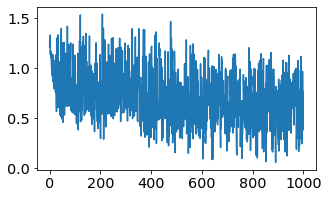

2000


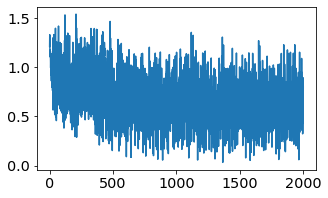

3000


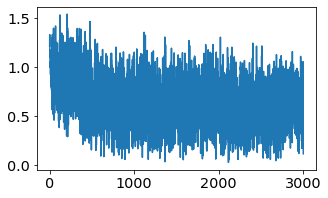

4000


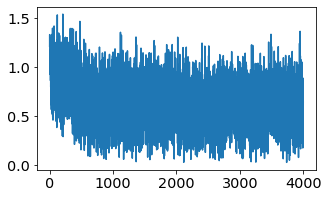

5000


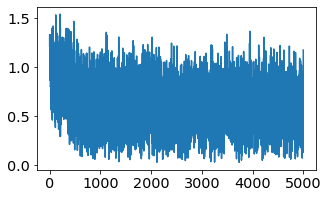

6000


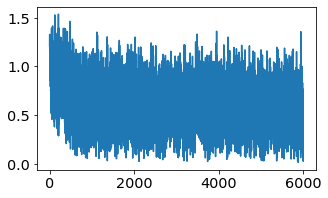

7000


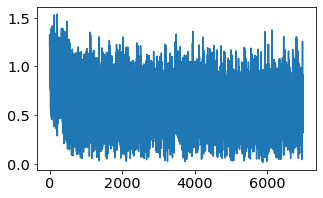

8000


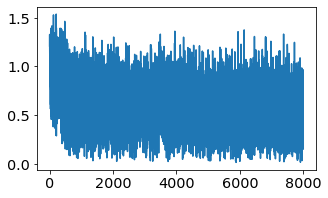

9000


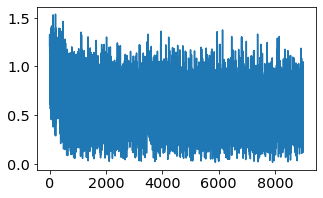

Finished Training


In [17]:
import torch.optim as optim

nlags = 2
mini_batch_size = 10
h_nodes = 50
net = MyNet(nlags, h_nodes, mRegimes)

print(net)

# create your optimizer
#optimizer = optim.SGD(net.parameters(), lr=0.5)
optimizer = optim.Adam(net.parameters())

# loss criterion is cross entropy for classification 
#  -- bascially the generalization of multi-class logistic
criterion = nn.CrossEntropyLoss()


Nepochs = 10000
loss_hist = []

for epoch in range(Nepochs):  # loop over the dataset multiple times


    # grab a minibatch -- randomize over starting point -- use only first bit of data for training
    idx = np.floor(np.random.uniform()* 1000 + nlags).astype(int)
    xb, yb = GetMinibatch(idx, mini_batch_size, nlags)

    # put inputs/targets into a tensor
    inputs = torch.tensor(xb, dtype=torch.float)  
    #print("inputs : ", inputs.shape)

    targets =  torch.tensor(yb, dtype=torch.long) 
    #print("targets : ", targets.shape)


    # zero the parameter gradients
    optimizer.zero_grad()

    # push inputs forward through the whole net
    outputs = net(inputs)
    # print("outputs: ", outputs.shape)


    # compute the loss associated with this output
    loss = criterion(outputs, targets)
    # print("loss: ", loss)

    # propogate the sensitivity of the output to the model parameters 
    # backwards through the computational graph
    loss.backward()

    # update the weights and biases by taking a SGD step
    optimizer.step()

    # store running loss
    loss_hist.append(  loss.item() )

    # plot output every 50 iterations
    if( (epoch % 1000 == 0) and (epoch>10) ):
        print(epoch)
        plt.figure(figsize=(5,3))
        plt.plot(loss_hist)
        plt.show()



print('Finished Training')

In [18]:
def plot_conf_mat(conf_mat, classes):

    fig = plt.figure(figsize=(12,15))
    
    ax = plt.subplot(1,2,1)
    
    ax.imshow(conf_mat, interpolation='nearest', cmap = plt.cm.Blues)
    
    ax.set(xticks=np.arange(conf_mat.shape[1]),
           yticks=np.arange(conf_mat.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    fmt = 'd'
    thresh = conf_mat.max() / 2.
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            ax.text(j, i, format(conf_mat[i, j], fmt),
                    ha="center", va="center",
                    color="white" if conf_mat[i, j] > thresh else "black") 
    
    
    conf_mat_nrm = conf_mat / np.sum(conf_mat, axis=1)[:, np.newaxis]
    
    ax = plt.subplot(1,2,2)
    
    ax.imshow(conf_mat_nrm, interpolation='nearest', cmap = plt.cm.Blues)
    
    ax.set(xticks=np.arange(conf_mat_nrm.shape[1]),
           yticks=np.arange(conf_mat_nrm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')
    
    fmt = '.2f'
    thresh = conf_mat_nrm.max() / 2.
    for i in range(conf_mat_nrm.shape[0]):
        for j in range(conf_mat_nrm.shape[1]):
            ax.text(j, i, format(conf_mat_nrm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if conf_mat_nrm[i, j] > thresh else "black")
            
            
    fig.tight_layout()      
    
    plt.show()



[2 2 2 2 2 2 2 1 2 2]
[2 2 2 2 2 2 2 2 2 1]
[[ 17  36   5]
 [ 10 178 117]
 [  5  99 533]]


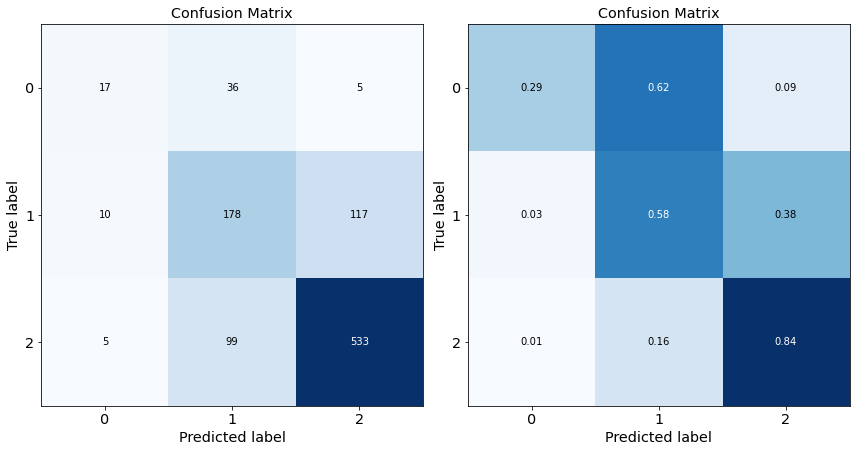

In [19]:
# let's look at prediction on the training data set
xb, yb = GetMinibatch(nlags+1, 1000,nlags)

inputs = torch.tensor(xb, dtype=torch.float)
outputs = net(inputs)

# compute probability distribution overp price movements
expfac =  np.minimum( np.exp(outputs.detach().numpy()), 1e200)
prob = expfac / np.sum( expfac, axis=1).reshape(-1,1)

# use maximum a posteriori estimate to pred the movement
y_pred = np.argmax(prob, axis=1)
print(y_pred[:10])
print(yb[:10])

conf_mat = confusion_matrix(yb, y_pred)
print(conf_mat)
plot_conf_mat(conf_mat,['0','1','2'])

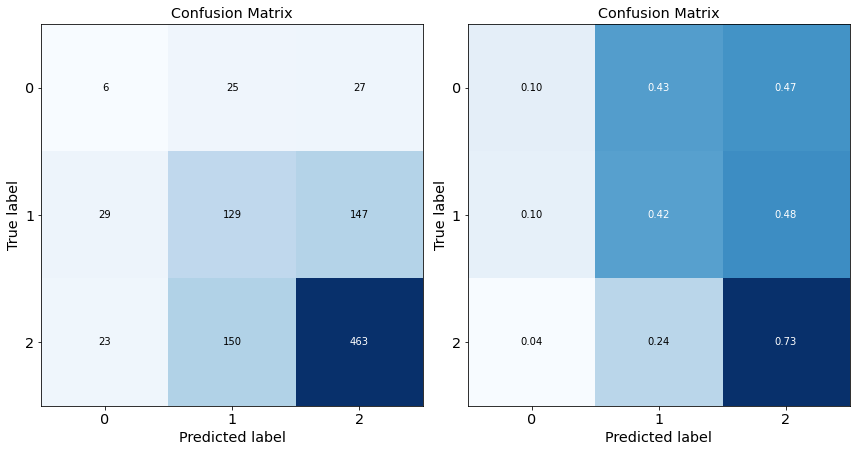

In [20]:
# look at what you get if you predict the previous regime will persist
conf_mat = confusion_matrix(yb[1:], yb[:-1])
plot_conf_mat(conf_mat,['0','1','2'])

[2 2 1 2 1 1 1 1 1 1]
[1 1 2 2 1 1 2 1 1 1]


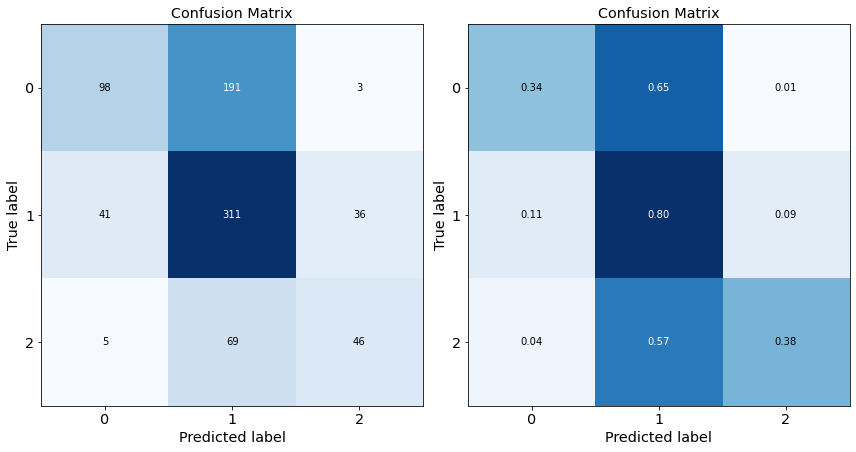

In [21]:
# now on the test data
# let's look at prediction on the training data set
xb, yb = GetMinibatch(1000+nlags+1, 800, nlags)

inputs = torch.tensor(xb, dtype=torch.float)
outputs = net(inputs)

# compute probability distribution overp price movements
expfac =  np.minimum( np.exp(outputs.detach().numpy()), 1e200)
prob = expfac / np.sum( expfac, axis=1).reshape(-1,1)

# use maximum a posteriori estimate to pred the movement
y_pred = np.argmax(prob, axis=1)
print(y_pred[:10])
print(yb[:10])

conf_mat = confusion_matrix(yb, y_pred)
plot_conf_mat(conf_mat,['0','1','2'])